Check the correlation between the performance of grounding and VGP identification

In [1]:
% cd /home/mayu-ot/durga/Experiments/loc_iparaphrasing/

from chainercv.utils import bbox_iou, non_maximum_suppression
import chainer
import numpy as np
import json
import pandas as pd
import tables
from chainer.dataset.convert import concat_examples
from sklearn.metrics import f1_score, precision_score, recall_score
from func.datasets.datasets import get_agg_roi_df
%matplotlib inline
import matplotlib.pyplot as plt

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
from func.datasets.datasets import BBoxDataset, PLCLCBBoxDataset, PreCompFeatDataset

In [3]:
p_bbox_data = PLCLCBBoxDataset('test')
pbbox_df = p_bbox_data.df
gt_bbox_data = BBoxDataset('test')
gtbbox_df = gt_bbox_data.df

In [5]:
df = pd.read_csv('data/phrase_pair_test.csv', index_col=0)

In [6]:
from IPython.html.widgets import IntProgress
from IPython.display import display

def lget_bbox(df, img_id, phr):
    ymin = df.at[(img_id, phr), 'ymin']
    xmin = df.at[(img_id, phr), 'xmin']
    ymax = df.at[(img_id, phr), 'ymax']
    xmax = df.at[(img_id, phr), 'xmax']
    return np.asarray([ymin, xmin, ymax, xmax])

ip = IntProgress(min=0, max=len(df))
display(ip)

ious1 = []
ious2 = []

for i, row in df.iterrows():
    im_id, phr1, phr2 = row[['image', 'original_phrase1', 'original_phrase2']]
    p_bbox1 = lget_bbox(pbbox_df, im_id, phr1)[None, :]
    p_bbox2 = lget_bbox(pbbox_df, im_id, phr2)[None, :]
    
    gt_bbox1 = lget_bbox(gtbbox_df, im_id, phr1)[None, :]
    gt_bbox2 = lget_bbox(gtbbox_df, im_id, phr2)[None, :]
    
    iou1 = bbox_iou(p_bbox1, gt_bbox1)
    iou2 = bbox_iou(p_bbox2, gt_bbox2)
    
    ious1.append(iou1[0])
    ious2.append(iou2[0])
    
    ip.value = i

plclc_ious1 = ious1
plclc_ious2 = ious2

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


IntProgress(value=0, max=81285)

In [14]:
syn_data = PreCompFeatDataset('test')

ip = IntProgress(min=0, max=len(syn_data))
display(ip)

ious1 = []
ious2 = []

for i in range(len(syn_data)):
    gt_bbox1, gt_bbox2 = syn_data.get_bbox(i)
    gt_bbox1 = np.asarray(gt_bbox1)
    gt_bbox2 = np.asarray(gt_bbox2)
    
    s_bbox1, s_bbox2 = syn_data.get_jbbox(i)
    
    iou1 = bbox_iou(s_bbox1[None,:], gt_bbox1[None,:])
    iou2 = bbox_iou(s_bbox2[None,:], gt_bbox2[None,:])
    
    ious1.append(iou1[0])
    ious2.append(iou2[0])
    
    ip.value = i
    
syn_ious1 = ious1
syn_ious2 = ious2

test data: 81285 pairs


IntProgress(value=0, max=81285)

In [17]:
import seaborn as sns
sns.set()

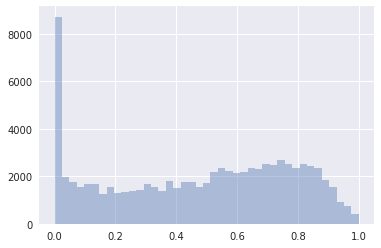

In [18]:
sns.distplot(ious1, kde=False)

In [31]:
# vision + langauge
def get_results(df_file, ious1, ious2):
    df = pd.read_csv(df_file)
    df['ious1'] = np.asarray(ious1)
    df['ious2'] = np.asarray(ious2)

    iou_thres = []
    f1_scores = []
    interval = 0.1
    for thres in np.arange(interval, 1+interval, interval):
        iou_mean = np.mean(df[['ious1', 'ious2']].values, axis=1)
        sub_data = df[(iou_mean >= thres-interval) & (iou_mean < thres)]
        score = f1_score(sub_data.ytrue, sub_data.ypred)
        print('%.1f-%.1f' % (thres-interval, thres), '%.2f' % (100.*score), '(%.1f%%)'%(100*len(sub_data) / len(df)))
        iou_thres.append(thres)
        f1_scores.append(100*score)
    
    return f1_scores, f1_score(df.ytrue, df.ypred) * 100

plclc_scores, _ = get_results('bo_out/frcnn+wea/plclc-roi/14-frcnn+wea-plclc-roi_20180413-165302/res_test.csv', plclc_ious1, plclc_ious2)
synthesized_scores, _ = get_results('bo_out/vis+lng+gtroi/20-gtroi_jittering_20180817-151855/res_test.csv', syn_ious1, syn_ious2)
vis_plclc_scores, _ = get_results('bo_out/frcnn+none/plclc-wo-vis/19-frcnn+none-plclc-wo-vis_20180520-043930/res_test.csv', plclc_ious1, plclc_ious2)
vis_synthesized_scores, _ = get_results('bo_out/vis+gtroi/12-gtroi_jittering_20180817-025111/res_test.csv', syn_ious1, syn_ious2)
plclc_lng_scores, lng_avr_score = get_results('bo_out/none+wea/wo-vis/11-none+wea-wo-vis_20180410-220417/res_test.csv', plclc_ious1, plclc_ious2)
synthesized_lng_scores, lng_avr_score = get_results('bo_out/none+wea/wo-vis/11-none+wea-wo-vis_20180410-220417/res_test.csv', syn_ious1, syn_ious2)

0.0-0.1 73.33 (4.9%)
0.1-0.2 74.60 (5.6%)
0.2-0.3 70.64 (8.5%)
0.3-0.4 75.34 (14.2%)
0.4-0.5 78.11 (17.5%)
0.5-0.6 82.06 (15.1%)
0.6-0.7 88.68 (14.4%)
0.7-0.8 90.88 (12.0%)
0.8-0.9 94.57 (6.5%)
0.9-1.0 94.67 (1.2%)
0.0-0.1 0.00 (0.0%)
0.1-0.2 88.89 (0.1%)
0.2-0.3 85.84 (1.0%)
0.3-0.4 87.00 (5.7%)
0.4-0.5 85.76 (16.5%)
0.5-0.6 86.04 (27.0%)
0.6-0.7 86.25 (27.7%)
0.7-0.8 89.02 (16.1%)
0.8-0.9 91.02 (5.1%)
0.9-1.0 89.11 (0.8%)
0.0-0.1 43.21 (4.9%)
0.1-0.2 39.92 (5.6%)
0.2-0.3 31.32 (8.5%)
0.3-0.4 33.66 (14.2%)
0.4-0.5 37.72 (17.5%)
0.5-0.6 53.36 (15.1%)
0.6-0.7 65.43 (14.4%)
0.7-0.8 76.60 (12.0%)
0.8-0.9 86.86 (6.5%)
0.9-1.0 91.61 (1.2%)
0.0-0.1 0.00 (0.0%)
0.1-0.2 33.33 (0.1%)
0.2-0.3 51.18 (1.0%)
0.3-0.4 54.63 (5.7%)
0.4-0.5 54.06 (16.5%)
0.5-0.6 55.77 (27.0%)
0.6-0.7 60.73 (27.7%)
0.7-0.8 63.55 (16.1%)
0.8-0.9 70.41 (5.1%)
0.9-1.0 74.61 (0.8%)
0.0-0.1 77.21 (4.9%)
0.1-0.2 76.11 (5.6%)
0.2-0.3 75.25 (8.5%)
0.3-0.4 75.14 (14.2%)
0.4-0.5 78.67 (17.5%)
0.5-0.6 83.01 (15.1%)
0.6-0.7 89.05 (

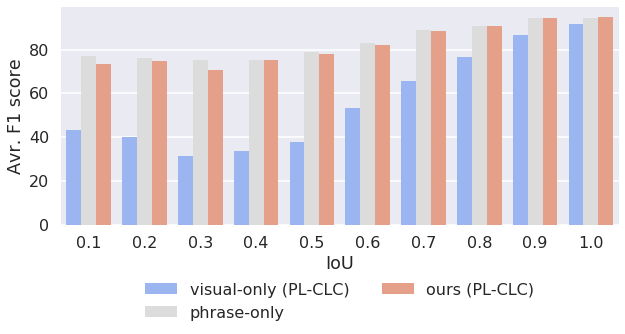

In [39]:
interval = 0.1
sns.set_context("poster")
palette=sns.color_palette("coolwarm", 3)
# palette=sns.diverging_palette(220, 20, n=5)

N = len(plclc_scores)

lng_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avr. F1 score': plclc_lng_scores,
                       'models': ['phrase-only']*N})

vis_plclc_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avr. F1 score': vis_plclc_scores,
                       'models': ['visual-only (PL-CLC)']*N})

plclc_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avr. F1 score': plclc_scores,
                      'models': ['ours (PL-CLC)']*N})

all_data = pd.concat((vis_plclc_df, lng_df, plclc_df))

plt.figure(figsize=(10, 4))
# plt.axhline(lng_avr_score, color='k', linestyle='--', label='phrase-only')
g = sns.barplot(x='IoU', y='Avr. F1 score', hue='models', data=all_data, palette=palette)
g.set_xticklabels(['%.1f'%x for x in np.arange(interval, 1+interval, interval)])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.savefig('figures/aaai/detailed_results_bar_plclc.pdf', bbox_inches='tight')

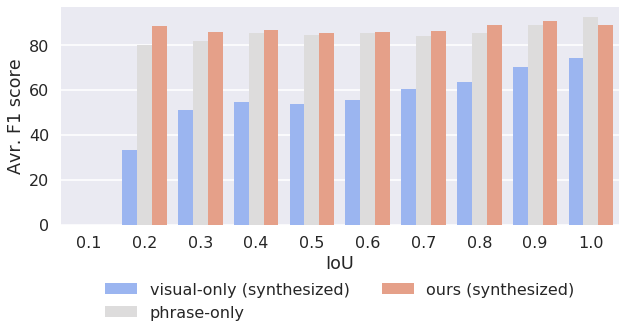

In [38]:
interval = 0.1
sns.set_context("poster")
palette=sns.color_palette("coolwarm", 3)
# palette=sns.diverging_palette(220, 20, n=5)

N = len(plclc_scores)

lng_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avr. F1 score': synthesized_lng_scores,
                       'models': ['phrase-only']*N})


vis_synthesized_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avr. F1 score': vis_synthesized_scores,
                       'models': ['visual-only (synthesized)']*N})

                       
synthesized_df = pd.DataFrame({'IoU': np.arange(interval, 1+interval, interval),
                      'Avr. F1 score': synthesized_scores,
                      'models': ['ours (synthesized)']*N})

all_data = pd.concat((vis_synthesized_df, lng_df, synthesized_df))

plt.figure(figsize=(10, 4))
# plt.axhline(lng_avr_score, color='k', linestyle='--', label='phrase-only')
g = sns.barplot(x='IoU', y='Avr. F1 score', hue='models', data=all_data, palette=palette)
g.set_xticklabels(['%.1f'%x for x in np.arange(interval, 1+interval, interval)])
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.savefig('figures/aaai/detailed_results_bar_synthesized.pdf', bbox_inches='tight')